In [1]:
import numpy as np
import datetime as dt
import pandas as pd
from functools import reduce
from glob import glob
import ntpath
from math import ceil

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
from sklearn import metrics
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from utils import settings
from utils.preprocessing import data_processing_end, get_file_names, data_processing_us_bls
from utils.visualization import units, visualize_features, test_stationarity, remove_non_stationarity

In [2]:
sns.set()
rc('text', usetex=False)

# initialize the list of all settings to be used in this file
settings.init()

## Data preparation

In [3]:
data = pd.read_csv("Data/dataset_monthly.csv", sep=';')
data_pct_change = pd.read_csv("Data/dataset_monthly_pct_change.csv", sep=';')
data['Date'] = pd.to_datetime(data['Date'])
data_pct_change['Date'] = pd.to_datetime(data_pct_change['Date'])

settings.add('ORIGINAL_COLS', data.columns)
settings.add('UNITS', units)  # units are in utils.visualization

data = pd.merge(data, data_pct_change, on='Date')

## Data visualization

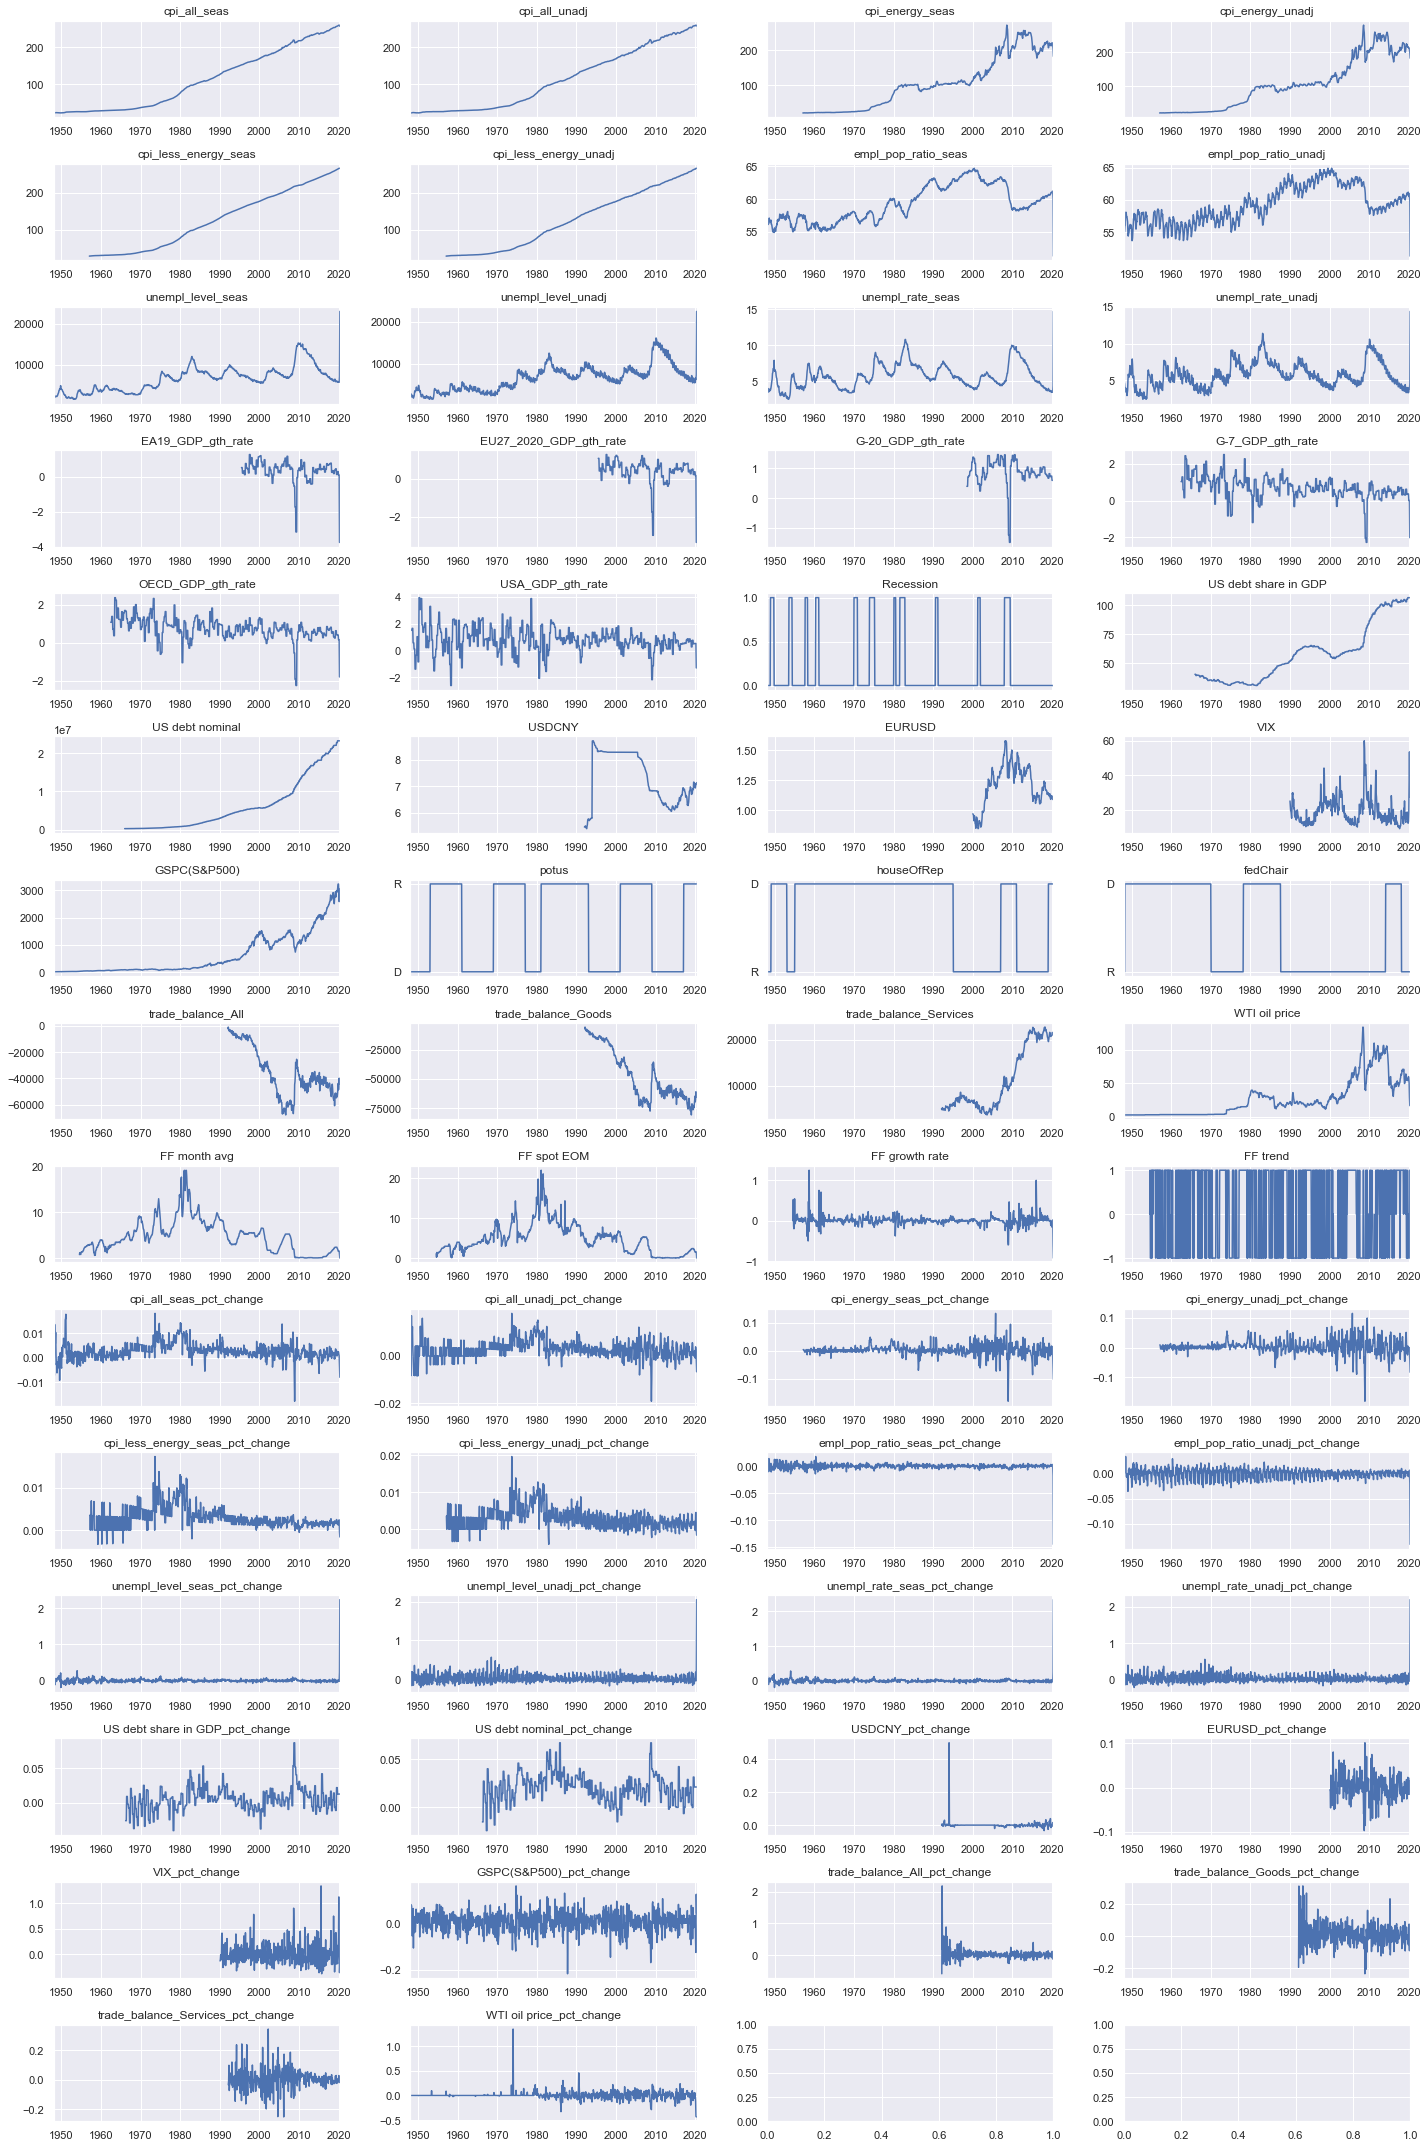

In [4]:
visualize_features(data=data,
                   date_col='Date',
                   ncols=4)

## Data processing: stationarity, normalization, correlation

In [5]:
Y_COL = ['FF month avg', 'FF spot EOM','FF growth rate', 'FF trend']
X, Y = data.drop(columns = Y_COL), data[Y_COL]

# handle political orientation categories: D = 1, R = 0
pol_columns = ['potus', 'houseOfRep', 'fedChair']
for col in pol_columns:
    X[col] = X[col] == 'D'
    
settings.add('NON_NUM_COLS', ['Date', 'Recession', 'potus', 'houseOfRep', 'fedChair'])
settings.add('NUM_COLS', [x for x in X.columns if x not in settings.get('NON_NUM_COLS')])

settings.add('START_DATE', dt.datetime(2000, 1, 1))
settings.add('END_DATE', dt.datetime(2019, 12, 1))
print(pd.Series(settings.settings_list))

ORIGINAL_COLS    Index(['Date', 'cpi_all_seas', 'cpi_all_unadj'...
UNITS            {'cpi_all_seas': 'Index 1982-84=100', 'cpi_all...
NON_NUM_COLS        [Date, Recession, potus, houseOfRep, fedChair]
NUM_COLS         [cpi_all_seas, cpi_all_unadj, cpi_energy_seas,...
START_DATE                                     2000-01-01 00:00:00
END_DATE                                       2019-12-01 00:00:00
dtype: object


### 1. Feature stationarity

https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000

http://www.real-statistics.com/time-series-analysis/stochastic-processes/dickey-fuller-test/

#### Dickey-Fuller test to ensure stationarity of variables

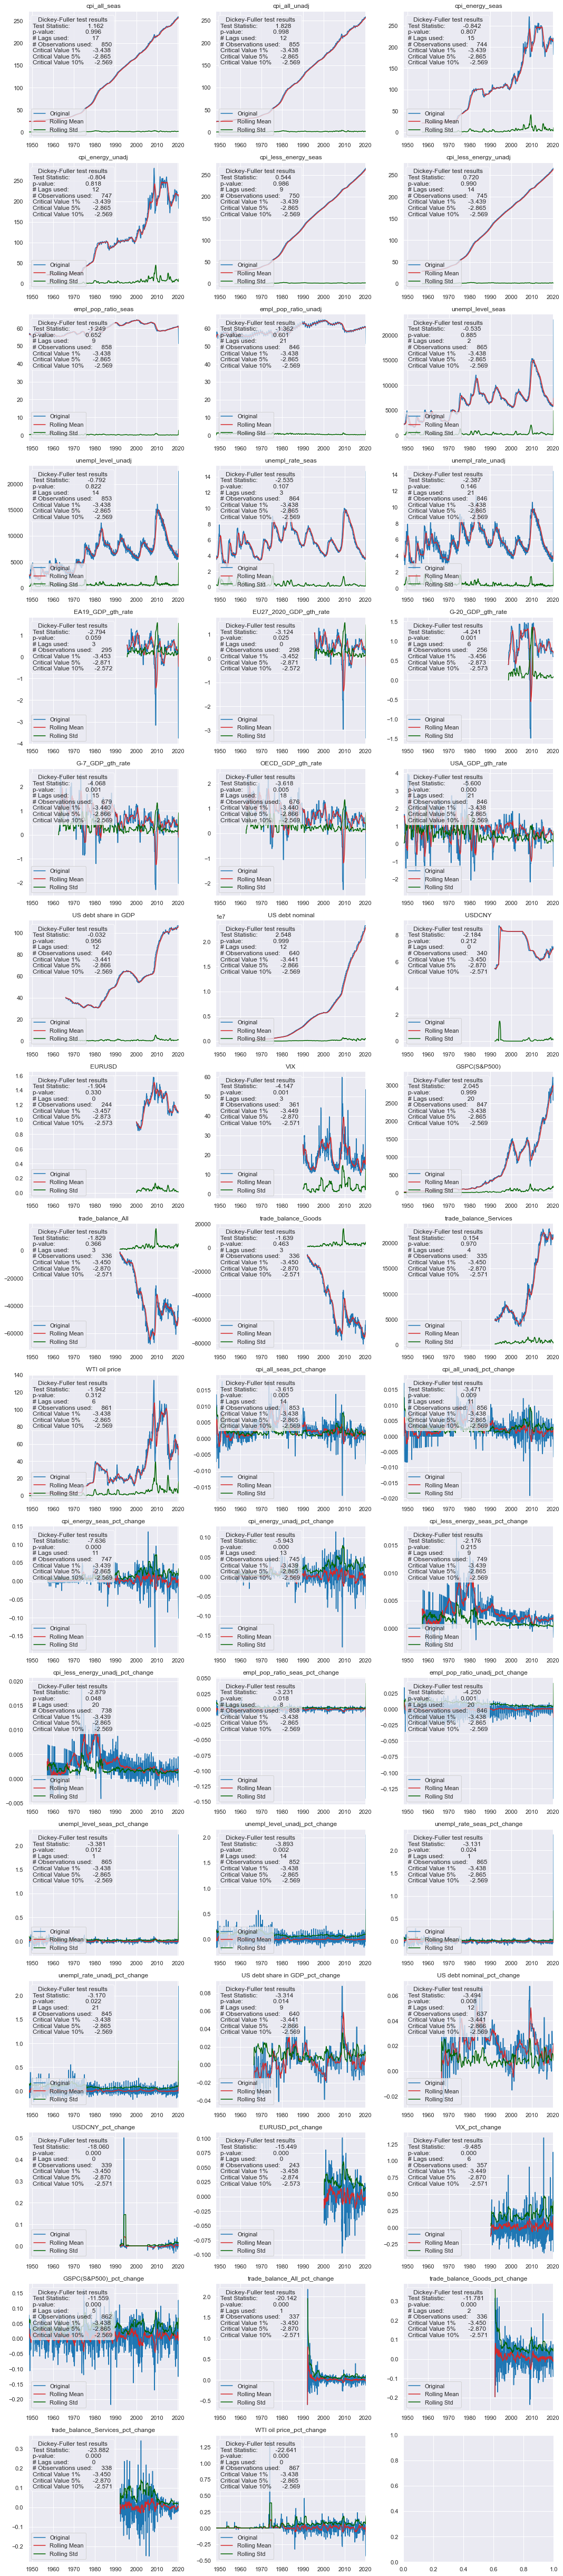

In [6]:
stat_results = test_stationarity(X,
                                columns=settings.get('NUM_COLS'),
                                date_col='Date',
                                stat_conf_level='5%',
                                height_per_ax=4,
                                print_graphs=True,
                                print_test_results=True,
                               )

#### Take only stationary features, keep one of  "_value" and "_pct_change"

In [7]:
remove_non_stationarity(X, stat_results)
settings.replace('NUM_COLS', [x for x in X.columns if x not in settings.get('NON_NUM_COLS')])


### 2. Feature normalization

In [8]:
X_scaled = preprocessing.StandardScaler().fit_transform(X[settings.get('NUM_COLS')])
X[settings.get('NUM_COLS')] = pd.DataFrame(X_scaled, columns=settings.get('NUM_COLS'))


### 3. Feature correlations 

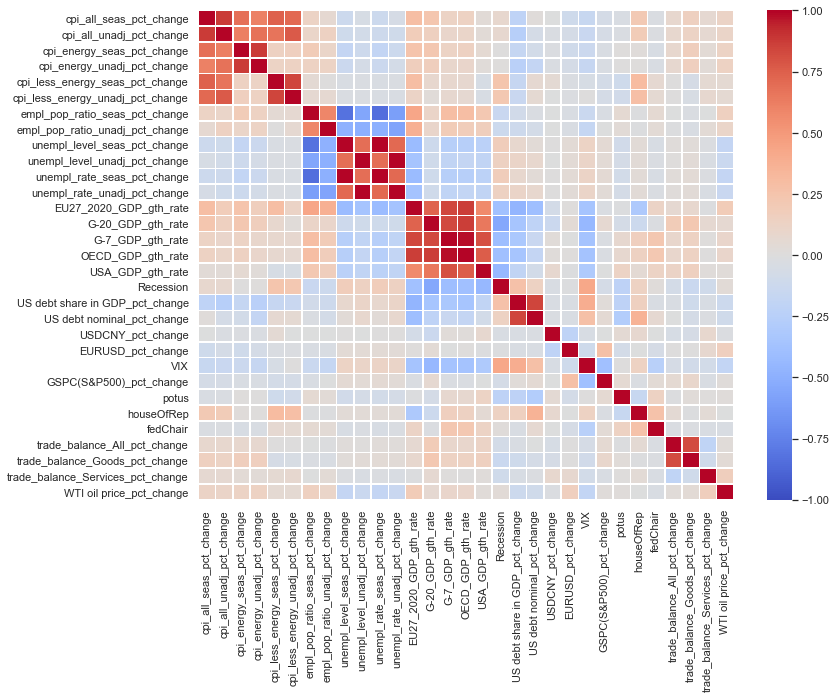

In [9]:
fig = plt.figure(figsize = (12, 9))
heat_map = sns.heatmap(X.corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

##### VIF analysis

In [10]:
# Remove all variables not corrected for seasonality
columns_kept = list(X.columns)

# Exclude features without seasonality correction
excl_columns_vif = [c for c in X.columns if c.lower().replace('_pct_change', '')[-5:] == 'unadj']

In [11]:
# Exclude features based on previous VIF analysis (iterative process)
excl_columns_vif += ['unempl_level_seas_pct_change', 'OECD_GDP_gth_rate', 'trade_balance_All_pct_change',
                     'cpi_all_seas_pct_change', 'G-7_GDP_gth_rate', 'empl_pop_ratio_seas_pct_change',
                     'US debt nominal_pct_change']

# Compute features to be analysed by VIF
for e in excl_columns_vif:
    try:
        columns_kept.remove(e)
    except: pass
columns_vif = []
for col in columns_kept:
    if col in settings.get('NUM_COLS') and col not in excl_columns_vif:
        columns_vif.append(col)

data_vif = X[columns_vif]
data_vif = data_vif.dropna()
VIF_factor = [variance_inflation_factor(data_vif.values, i) for i in range(data_vif.shape[1])]
vif = pd.DataFrame({"VIF_factor": VIF_factor, "features": data_vif.columns})
print(vif)

    VIF_factor                           features
0     1.228296         cpi_energy_seas_pct_change
1     1.549863    cpi_less_energy_seas_pct_change
2     1.667732        unempl_rate_seas_pct_change
3     4.098082             EU27_2020_GDP_gth_rate
4     4.195415                  G-20_GDP_gth_rate
5     2.658482                   USA_GDP_gth_rate
6     1.679615    US debt share in GDP_pct_change
7     1.192086                  USDCNY_pct_change
8     1.169229                  EURUSD_pct_change
9     2.247679                                VIX
10    1.635214            GSPC(S&P500)_pct_change
11    1.166827     trade_balance_Goods_pct_change
12    1.099074  trade_balance_Services_pct_change
13    1.311867           WTI oil price_pct_change


##### Kept features

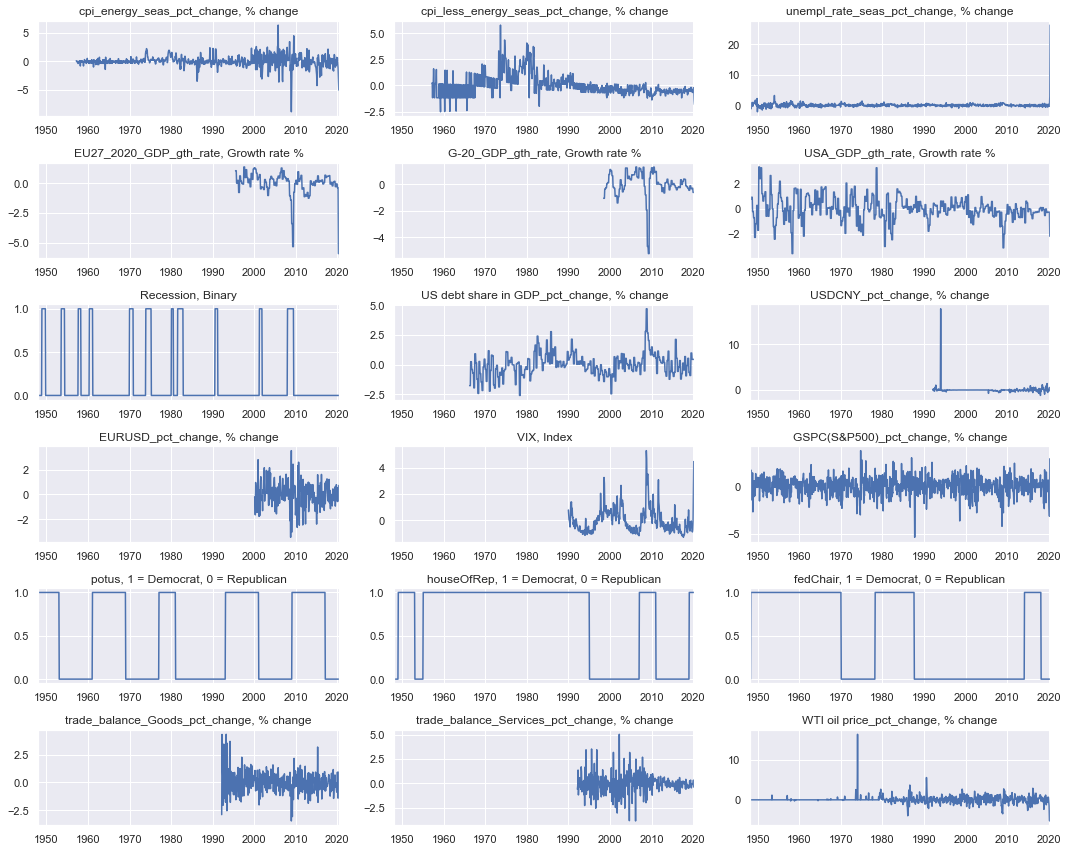

In [12]:
visualize_features(data=X,
                   columns=columns_kept,
                   date_col='Date', 
                   titles=units,
                   ncols=3)


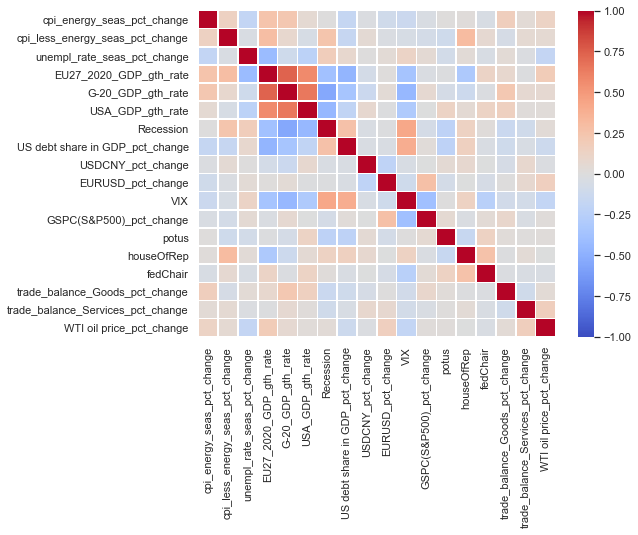

In [13]:
plt.figure(figsize = (8, 6))
heat_map = sns.heatmap(X[columns_kept].corr(), cmap='coolwarm', linewidth=.5, vmin=-1, vmax=1)

## First models

In [14]:


model_names = []
models = {}

In [15]:
model_name="Baseline"
model_names.append(model_name)


X.dropna(inplace=True)
X.head()

,Date,cpi_all_seas_pct_change,cpi_all_unadj_pct_change,cpi_energy_seas_pct_change,cpi_energy_unadj_pct_change,cpi_less_energy_seas_pct_change,cpi_less_energy_unadj_pct_change,empl_pop_ratio_seas_pct_change,empl_pop_ratio_unadj_pct_change,unempl_level_seas_pct_change,...,EURUSD_pct_change,VIX,GSPC(S&P500)_pct_change,potus,houseOfRep,fedChair,trade_balance_All_pct_change,trade_balance_Goods_pct_change,trade_balance_Services_pct_change,WTI oil price_pct_change
624,2000-01-31,0.059165,0.053420,0.359347,-0.018897,-0.044071,0.166148,0.524498,-1.065780,0.058311,...,-0.209220,0.520334,-0.652310,True,False,False,0.046944,0.211490,-0.013474,0.924239
625,2000-02-29,0.410603,0.834684,1.438365,1.447900,-0.723451,0.161968,0.015326,0.311058,0.252719,...,-0.345889,0.617103,2.155004,True,False,False,0.486412,1.085404,-0.068958,0.170702
626,2000-03-31,0.934405,1.448635,2.073959,1.862471,-0.048546,0.767780,0.015326,0.310094,-0.306642,...,-1.659453,0.890409,-0.909130,True,False,False,0.118157,0.305063,-0.365045,-1.757813
627,2000-04-30,-1.003879,-0.577978,-1.458211,-0.651531,-0.500727,-0.455236,0.269124,0.615781,-0.572332,...,0.959606,0.556949,-0.695731,True,False,False,-0.551698,-0.762687,1.601381,1.393560
628,2000-05-31,-0.302490,-0.423637,-0.503391,-0.026866,-0.053616,-0.860161,-0.744891,-0.302258,0.537694,...,0.521008,0.019490,0.405987,True,False,False,0.085245,-0.047268,-1.846563,1.244817
